In [1]:
from dotenv import load_dotenv
load_dotenv("../config.env")

True

In [9]:
from coamp_graph import Graph
import coamp_graph_notebook_utils

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from ast import literal_eval
from fitter import Fitter
from collections import Counter
from scipy.stats import gamma

In [5]:
### Building Lengths Distribution ###

In [6]:
# replace with path to interval files
user_path = "/users/michael/Downloads/"

In [7]:
# get depmap/pcawg/tcga ecDNA features list
depmap = user_path + "depmap_interval_files/"
pcawg_tcga = user_path + "pcawg_tcga_cutoff_passed_interval_files/"

files = [depmap + i for i in os.listdir(depmap)] + [pcawg_tcga + i for i in os.listdir(pcawg_tcga)]

depmap_pcawg_tcga_features = []
for f in files:
    depmap_pcawg_tcga_features.append(pd.read_csv(f, sep='\t', header=None))

# get depmap/pcawg/tcga ecDNA feature names
dpt_feature_names = [i for i in os.listdir(depmap)] + [i for i in os.listdir(pcawg_tcga)]
dpt_feature_names = [i.split('_intervals')[0] for i in dpt_feature_names]

In [11]:
# get ccle ecDNA features list
ccle_df, __ = coamp_graph_notebook_utils.concat_projects(['ccle'])
ccle_ecdna = ccle_df[ccle_df["Classification"] == "ecDNA"]

ccle_features = []
ccle_feature_names = []

for __, feature in ccle_ecdna.iterrows():
    # Find all matches (for multiple occurrences per row)
    matches = re.findall(r"'?([\dXY]+):(\d+)-(\d+)'?", str(feature['Location']))
    if len(matches) > 0:
        df = pd.DataFrame(matches, columns=[0, 1, 2])
        df[1] = pd.to_numeric(df[1])
        df[2] = pd.to_numeric(df[2])
        ccle_features.append(df)
        ccle_feature_names.append(feature['Feature_ID'])

In [12]:
# combine features lists and report counts
all_feature_names = dpt_feature_names + ccle_feature_names
all_features = depmap_pcawg_tcga_features + ccle_features

print(f"Total features: {len(depmap_pcawg_tcga_features)} (depmap/pcawg/tcga) + {len(ccle_features)} (ccle) = {len(all_features)} features")
print(f"Total intervals: {sum([len(feature) for feature in all_features])} intervals")

Total features: 1302 (depmap/pcawg/tcga) + 360 (ccle) = 1662 features
Total intervals: 7114 intervals


In [13]:
# merge nearby intervals closer than MERGE_CUTOFF bp apart
def merge_intervals(features, MERGE_CUTOFF=50000):
    """
    Parameters: 
        features (list): each feature is a dataframe of intervals
        MERGE_CUTOFF (int): merge intervals < cutoff distance (bp)
    Return: 
        merged_intervals (list): list of features[list of merged intervals[list of chr,start,end]]
    """
    feature_list = []
    for feature in features:
        merged_intervals = []
        matches = []
        for __, interval in feature.iterrows():
            matches.append(interval.tolist())
        
        curr_interval = matches[0]
        for i in range(len(matches)):            
            # if end is reached, add the current interval
            if i == len(matches) - 1:
                merged_intervals.append(curr_interval)

            # if this interval can be merged with the next, extend the current interval
            elif matches[i][0] == matches[i+1][0] and matches[i+1][1] - matches[i][2] <= MERGE_CUTOFF:
                curr_interval[2] = matches[i+1][2]

            # otherwise add the current interval and reset
            else:
                merged_intervals.append(curr_interval)
                curr_interval = matches[i+1]
        
        if matches != [[]] or matches != []:
            feature_list.append(merged_intervals)
    
    print(f"{sum([len(f) for f in feature_list])} intervals after merging intervals closer than {MERGE_CUTOFF}bp apart")
    return feature_list

In [14]:
# remove intervals larger than MAX_INTERVAL_SIZE bp
def remove_large_intervals(feature_list, MAX_INTERVAL_SIZE=5000000):
    cleaned_features = []
    for feature in feature_list:
        to_add = []
        for interval in feature:
            if interval[2] - interval[1] <= MAX_INTERVAL_SIZE:
                to_add.append(interval)
        if to_add:
            cleaned_features.append(to_add)

    print(f"{sum([len(f) for f in cleaned_features])} intervals after removing intervals larger than {MAX_INTERVAL_SIZE}bp")
    return cleaned_features

In [16]:
# base parameters
feature_list = remove_large_intervals(merge_intervals(all_features))

4921 intervals after merging intervals closer than 50000bp apart
4830 intervals after removing intervals larger than 5000000bp


In [30]:
# test parameters
MC = 25000
MIS = 500000
feature_list = remove_large_intervals(merge_intervals(all_features, MC), MIS)

5184 intervals after merging intervals closer than 25000bp apart
3565 intervals after removing intervals larger than 500000bp


In [31]:
### Fitting pdD Model to Lengths Distribution ###

In [32]:
interval_lengths = [i[2] - i[1] for f in feature_list for i in f]
intervals_df = pd.DataFrame(interval_lengths, columns=['Lengths (bp)'])
intervals_df.describe()

,Lengths (bp)
count,3565.000000
mean,131142.379523
std,136616.601734
min,2.000000
25%,16201.000000
50%,79373.000000
75%,210456.000000
max,499743.000000


2025-08-05 15:27:03.483 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.0)


       sumsquare_error          aic          bic    kl_div  ks_statistic  \
gamma     4.748760e-10  2903.431587  2921.968345  0.241662      0.209037   

           ks_pvalue  
gamma  3.946582e-137  


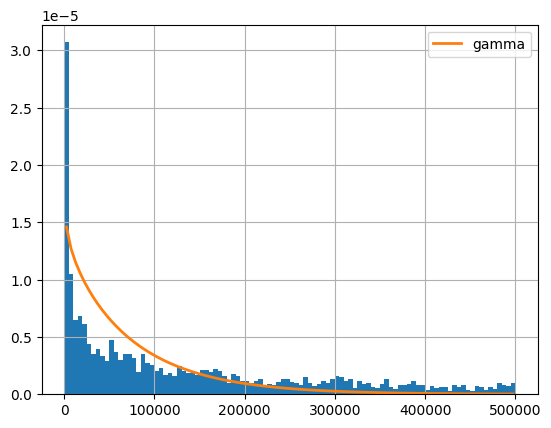

In [38]:
f = Fitter(intervals_df, distributions=['gamma'])
f.fit()
print(f.summary())

In [29]:
shape, loc, scale = gamma.fit(intervals_df)
print(f"Shape: {shape}, Location: {loc}, Scale: {scale}")

Shape: 0.7420123072378633, Location: 1.9999999999999998, Scale: 203145.72909328266


In [ ]:
### Finding Rate of M_SC & M_MC ###

In [ ]:
# M_SC
def multi_interval_rate(features, MULTI_INTERVAL_MIN_DISTANCE=50000, same_chr_only=False):
    """
    |ecDNA features containing multiple intervals [at least two from the] same chromosome, 
    where at least two of the intervals are more than [50kbp] apart| / |all ecDNA features|
    """
    multi_interval_count = 0
    for feature in features:
        if same_chr_only:
            chr_set = set([interval[0] for interval in feature])
            if len(chr_set) > 1:
                continue
        
        if (len(feature) > 0):
            i = feature[0]
            for j in feature[1:]:
                if i[0] == j[0] and j[1] - i[2] > MULTI_INTERVAL_MIN_DISTANCE:
                    multi_interval_count += 1
                    break
                i = j
    return multi_interval_count / len(features) 

In [ ]:
# M_SC parameter sweep

# generate distances and rates
min_distances = np.arange(0, 1_000_001, 1000)
rates = [multi_interval_rate(feature_list, d) for d in min_distances]

# plot
plt.figure(figsize=(12, 6))
plt.plot(min_distances, rates, color='royalblue', linewidth=2, label='Rate')
plt.fill_between(min_distances, rates, color='royalblue', alpha=0.3)

# label marker positions
for marker in [50_000, 250_000, 1_000_000]:
    idx = np.where(min_distances == marker)[0][0]
    x_val = min_distances[idx]
    y_val = rates[idx]
    
    plt.plot(x_val, y_val, 'o', color='royalblue', markersize=8)
    plt.text(x_val, y_val + 0.01, f'{y_val:,.4f} ({x_val/1000:.0f} kbp)', color='royalblue', fontsize=14,
             ha='left', va='bottom', fontweight='bold')
    
# formatting
plt.title('Multi-interval Rate vs. Minimum Distance Threshold', fontsize=16)
plt.xlabel('MULTI_INTERVAL_MIN_DISTANCE', fontsize=12)
plt.ylabel('multi_interval_rate', fontsize=12)
plt.ylim(0, 1)
plt.xlim(min_distances.min(), min_distances.max())
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# M_MC
def multi_chromosomal_rate(features, MULTI_CHR_MIN_SIZE=20000):
    """
    |ecDNA features containing at least two intervals from different chromosomes, 
    where both of the intervals are greater than 20kbp in size| / |all ecDNA features|
    """
    multi_chromosomal_count = 0
    for feature in features:
        chr_set = set([interval[0] for interval in feature if interval[2]-interval[1] > MULTI_CHR_MIN_SIZE])
        if len(chr_set) > 1:
            multi_chromosomal_count += 1
    return multi_chromosomal_count / len(features)

In [ ]:
# M_MC parameter sweep

# generate distances and rates
min_distances = np.arange(0, 20001, 1000)
rates = [multi_chromosomal_rate(feature_list, d) for d in min_distances]

# plot
plt.figure(figsize=(12, 6))
plt.plot(min_distances, rates, color='royalblue', linewidth=2, label='Rate')
plt.fill_between(min_distances, rates, color='royalblue', alpha=0.3)

# label marker positions
for marker in [0, 10000, 20000]:
    idx = np.where(min_distances == marker)[0][0]
    x_val = min_distances[idx]
    y_val = rates[idx]
    
    plt.plot(x_val, y_val, 'o', color='royalblue', markersize=8)
    plt.text(x_val, y_val + 0.01, f'{y_val:,.4f} ({x_val/1000:.0f} kbp)', color='royalblue', fontsize=14,
             ha='left', va='bottom', fontweight='bold')
    
# formatting
plt.title('Multi-chromosomal Rate vs. Minimum Size Threshold', fontsize=16)
plt.xlabel('MULTI_CHR_MIN_SIZE', fontsize=12)
plt.ylabel('multi_chromosomal_rate', fontsize=12)
plt.ylim(0, 1)
plt.xlim(min_distances.min(), min_distances.max())
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
### Identifying Features by Name ###

In [ ]:
def features_with_intervals_of_distance(features, min_distance, max_distance):
    """
    return list of feature names that have distances between intervals on the same chromosome in the range (min_distance, max_distance)
    """
    feature_names = []
    # feature_sublist = []
    for index, feature in enumerate(features):
        if (len(feature) > 0):
            i = feature[0]
            for j in feature[1:]:
                if i[0] == j[0]:
                    distance = j[1] - i[2]
                    if distance > min_distance and distance < max_distance:
                        feature_names.append(all_feature_names[index])
                        # feature_sublist.append(feature)
                i = j
    return feature_names # , feature_sublist

In [ ]:
features_with_intervals_of_distance(feature_list, 495000, 505000)

In [ ]:
def features_with_intervals_of_length(features, min_length, max_length=100000000):
    """
    return list of feature names that have intervals of at least length kb
    """
    feature_names = []
    for index, feature in enumerate(features):
        if (len(feature) > 0):
            for j in feature:
                length = j[2] - j[1]
                if length >= min_length and length <= max_length:
                    feature_names.append(f"{all_feature_names[index]}: {length}bp")
    return feature_names # , feature_sublist

In [ ]:
features_with_intervals_of_length(features=feature_list, min_length=6500000, max_length=7000000)

In [ ]:
### Plotting Distances Between Intervals on the Same Chromosome ###

In [ ]:
def same_chr_interval_distances(features):
    """
    distances between interval endpoints from consecutive intervals of the same chromosome
    """
    distances = []
    for feature in features:
        if (len(feature) > 0):
            i = feature[0]
            for j in feature[1:]:
                if i[0] == j[0]:
                    distances.append(j[1] - i[2])
                i = j
    return distances

In [ ]:
distances = same_chr_interval_distances(feature_list)
pd.DataFrame(distances, columns=["Distance (bp)"]).describe()

In [ ]:
# NOTE: Requires seaborn
import seaborn as sns

# Freedman–Diaconis rule to calculate optimal bin width
q25, q75 = np.percentile(distances, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr * len(distances) ** (-1/3)
bin_width = max(bin_width, 1)  # Avoid zero or negative
num_bins = int((max(distances) - min(distances)) / bin_width)

# plot
plt.figure(figsize=(12, 6))
sns.histplot(distances, bins=num_bins, color='royalblue',
             edgecolor='white', alpha=0.8, stat='density')

# Formatting
plt.title('Distances Between Consecutive Interval Endpoints', fontsize=16)
plt.xlabel('Distance (bp)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxenplot(x=distances, color='royalblue', k_depth='proportion', outlier_prop=0.01)

plt.xlabel('Distance (bp)')
plt.title('Distances Between Consecutive Interval Endpoints', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
def every_fifth_percentile(data):
    data = np.array(data)
    percentiles = np.arange(5, 100, 5)
    return {p: np.percentile(data, p) for p in percentiles}

# Calculate the percentiles and format them
def print_percentiles_aligned(data):
    results = every_fifth_percentile(data)

    # Format and find max width for alignment
    formatted = {k: f"{int(round(v)):,}" for k, v in results.items()}
    max_width = max(len(val) for val in formatted.values())

    for k in sorted(formatted):
        print(f"{k:>2}th percentile: {formatted[k]:>{max_width}}")

In [ ]:
print_percentiles_aligned(distances)

In [ ]:
distances_truncated = [d for d in distances if d > 50000 and d < 10_000_000]
pd.DataFrame(distances_truncated, columns=["Distance (bp)"]).describe()

In [ ]:
# Freedman–Diaconis rule to calculate optimal bin width
q25, q75 = np.percentile(distances_truncated, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr * len(distances_truncated) ** (-1/3)
bin_width = max(bin_width, 1)  # Avoid zero or negative
num_bins = int((max(distances_truncated) - min(distances_truncated)) / bin_width)

# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(distances_truncated, bins=num_bins, 
#              kde=True, 
             color='royalblue', edgecolor='white', alpha=0.8, stat='density')

# Formatting
plt.title('Distances Between Consecutive Interval Endpoints btwn 50kbp and 10Mbp', fontsize=16)
plt.xlabel('Distance (bp)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.tight_layout()
plt.show()
